In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint
from Utilities.basic_units import radians

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [34]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'Compton'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '164'
path = f'TDE/{folder}{check}/{snap}'
is_tde = True

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = 2 * Rt * (Mbh/mstar)**(1/3)

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2

theta_width = 0.02


In [35]:
def sort_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]
 
    return np.array(z)

def to_cylindric(x,y):
    radius = np.sqrt(x**2+y**2)
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    # theta_coord go from -pi to pi with negative values in the 3rd and 4th quadrant. You want to switch 
    theta_broadcasted = -theta_coord
    return theta_broadcasted, radius

def from_cylindric(theta, r):
    # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
    theta = -theta
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, a):
    # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
    theta = -theta
    p = 2 * a
    radius = p / (1 + np.cos(theta))
    return radius

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    if np.abs(theta_chosen - np.pi/2) < 0.1: # if theta is close to pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data < 0) # only the lower part
    elif np.abs(theta_chosen + np.pi/2) < 0.1: # if theta is close to -pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data > 0) # only the upper part
    else:
        # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
        m = np.tan(-theta_chosen)
        condition_coord = np.abs(y_data - m * x_data) < dim_data
        if np.abs(theta_chosen) < 0.1: # if theta is close to 0
            condition_coord = np.logical_and(condition_coord, x_data >= 0)
        elif np.abs(theta_chosen) == np.pi:
            condition_coord = np.logical_and(condition_coord, x_data < 0)
        elif np.logical_and(theta_chosen > 0, theta_chosen != np.pi): # if theta is in the third or fourth quadrant
            condition_coord = np.logical_and(condition_coord, y_data < 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data > 0)
    return condition_coord

# def avg_consecutive_triplets(array, i, choose):
#     if choose == 'before':
#         triplet = array[i-3:i+1]
#     else:
#         triplet = array[i:i+3+1]
#     avg = sum(triplet) / 3

#     if choose == 'before':
#         return avg, i-3
#     else: 
#         return avg, i+3

def median_array(points, window_size = 7):
    n = len(points)
    half_window = window_size // 2
    
    medians = np.copy(points) 
    
    for i in range(half_window, n-half_window): #I don't care of the first/last points
        window = points[i-half_window:i+window_size]
        median = np.median(window)
        medians[i]= median
    
    return np.array(medians)

def find_width(x_mid, y_mid, dim_mid, den_mid, theta_cm):
    threshold = 1/3
    # find the normal plane 
    condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_cm)
    x_plane = x_mid[condition_coord]
    y_plane = y_mid[condition_coord]
    r_plane = np.sqrt(x_plane**2 + y_plane**2)
    den_plane = den_mid[condition_coord]

    #above R0
    condition_r = r_plane > R0
    r_plane = r_plane[condition_r]
    x_plane = x_plane[condition_r]
    y_plane = y_plane[condition_r]
    den_plane = den_plane[condition_r]

    # sort 
    r_plane = list(r_plane)
    x_plane_sorted = sort_list(x_plane, r_plane)
    y_plane_sorted = sort_list(y_plane, r_plane)
    den_plane_sorted = sort_list(den_plane, r_plane)
    den_median_plane_sorted = median_array(den_plane_sorted)

    # find the cm of the plane
    idx_cm = np.argmax(den_plane_sorted)    
    x_cm = x_plane_sorted[idx_cm]
    y_cm = y_plane_sorted[idx_cm]
    den_cm = den_plane_sorted[idx_cm]
    
    # walk before and after the cm till you find a density 3 times smaller
    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > threshold * den_cm and idx_step > 0:
        idx_step -= 1
        den_tube = den_median_plane_sorted[idx_step] #den_plane_sorted[idx_step]
    idx_before = idx_step+1
    x_low = x_plane_sorted[idx_before]
    y_low = y_plane_sorted[idx_before]
    den_low = den_tube

    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > threshold * den_cm and idx_step < len(den_plane_sorted) - 1:
        idx_step += 1
        den_tube  = den_median_plane_sorted[idx_step] #den_plane_sorted[idx_step]
    idx_after = idx_step-1
    x_high = x_plane_sorted[idx_after]
    y_high = y_plane_sorted[idx_after]
    den_high = den_tube
    
    return x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high

def find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    cm = np.zeros((3,len(theta_arr)))
    upper_tube = np.zeros((3,len(theta_arr)))
    lower_tube = np.zeros((3,len(theta_arr)))
    for i,theta in enumerate(theta_arr):
        x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high = find_width(x_mid, y_mid, dim_mid, den_mid, theta)
        cm[0][i], cm[1][i], cm[2][i] = x_cm, y_cm, den_cm
        lower_tube[0][i], lower_tube[1][i], lower_tube[2][i] = x_low, y_low, den_low
        upper_tube[0][i], upper_tube[1][i], upper_tube[2][i] = x_high, y_high, den_high
    
    return cm, upper_tube, lower_tube

def find_streams(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    # first run to find the maxima (1 for every theta in theta_arr!). NB: the could be on different streams
    cm, upper_tube, lower_tube = find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr) 
    second_cm = []
    for i in range(len(cm[0])): #cm has 3 rows and len(theta_arr) columns
        #find again the normal plane
        condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_arr[i])
        x_norm = x_mid[condition_coord]
        y_norm = y_mid[condition_coord]
        r_norm = np.sqrt(x_norm**2 + y_norm**2)

        den_norm = den_mid[condition_coord]
        x_upper = upper_tube[0][i]
        y_upper = upper_tube[1][i]
        r_upper = np.sqrt(x_upper**2 + y_upper**2)
        x_lower = lower_tube[0][i]
        y_lower = lower_tube[1][i]
        r_lower = np.sqrt(x_lower**2 + y_lower**2)

        cond_rlow = np.logical_and(r_norm > R0, r_norm < r_lower)
        x_second = x_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        y_second = y_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        den_second = den_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        idx_cm2 = np.argmax(den_second)
        if den_second[idx_cm2] > cm[2][i]/3:
            second_cm.append([x_second[idx_cm2], y_second[idx_cm2], den_second[idx_cm2]])
    # broadcast as cm
    second_cm = np.transpose(second_cm)
    return cm, second_cm

def parameters_orbit(p, a):
    En = G * Mbh * (p**2 * (a-Rs) - a**2 * (p-Rs)) / ((a**2-p**2) * (p-Rs) * (a-Rs))
    L = np.sqrt(2 * a**2 * (En + G*Mbh/(a-Rs)))
    return En, L

def solvr(x, theta):
    _, L = parameters_orbit(Rp, apo)
    u,y = x
    res =  np.array([y, (-u + G * Mbh / ((1 - Rs*u) * L)**2)])
    return res

def Witta_orbit(theta_data):
    u,y = odeint(solvr, [0, 0], theta_data).T 
    r = 1/u
    return r

Load data

In [36]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Mass, Den, Press, Temp = make_tree(path, snap, is_tde, energy = False)

R = np.sqrt(X**2 + Y**2 + Z**2)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
dim_cell = Vol**(1/3) # according to Elad
theta, Rcyl = to_cylindric(X,Y)
tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

days after disruption: 1.3532153925058021 // t_fall: 2.5777261297507925 // sim_time: 73.40236449912129


Text(0.5, 1.0, '$\\theta$ = -0.79')

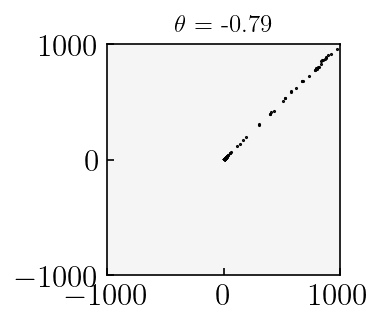

In [37]:
# # check if anglese are correct
# angle_check = -np.pi/4
# plt.figure(figsize=(2,2))
# plt.plot(X[np.abs(theta - angle_check) < 0.01], Y[np.abs(theta - angle_check) < 0.01], 'o', markersize = 0.5, c='k')
# plt.xlim(-1000,1000)
# plt.ylim(-1000,1000)
# plt.title(r'$\theta$ = '+ f'{np.round(angle_check,2)}')

Analytic curves

In [38]:
theta_lim = 3/4 * np.pi
theta_arr = np.arange(-theta_lim, theta_lim, 0.01) 

# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

# Parabolic orbit
theta_arr_kep = np.arange(0, 2*np.pi, 0.01)
r_orbit = keplerian_orbit(theta_arr_kep, a = Rp)
x_orbit, y_orbit = from_cylindric(theta_arr_kep, r_orbit) 

# Witta
theta_arr_kep = np.arange(-np.pi, np.pi, 0.01)
Witta_r = Witta_orbit(theta_arr_kep)
x_Witta_orbit, y_Witta_orbit = from_cylindric(theta_arr_kep, Witta_r) 

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_39152/450599208.py:189: RuntimeWarning: divide by zero encountered in divide
  r = 1/u


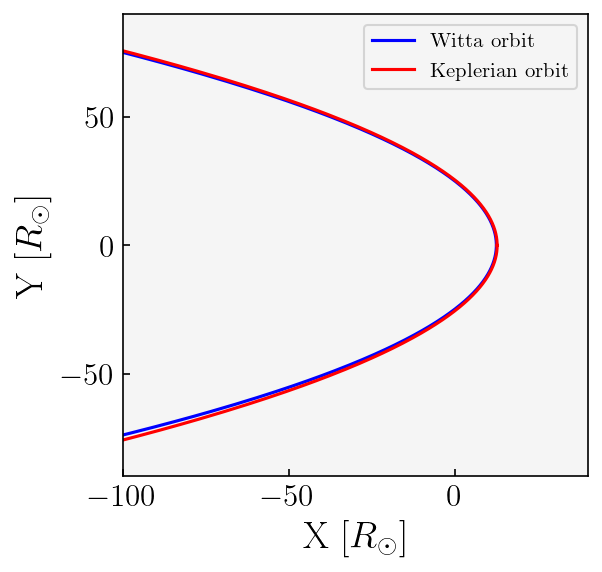

In [39]:
plt.figure(figsize=(4,4))
plt.plot(x_Witta_orbit, y_Witta_orbit, c='b',  label='Witta orbit')
plt.plot(x_orbit, y_orbit, c='r',  label='Keplerian orbit')
plt.xlim(-100,40)
plt.ylim(-90, 90)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.legend()

In [40]:
# Cross section at midplane
midplane = np.abs(Z) < dim_cell

X_cross = X[midplane]
Y_cross = Y[midplane]
VX_cross = VX[midplane]
VY_cross = VY[midplane]
Vol_cross = Vol[midplane]
dim_cross = dim_cell[midplane]
Temp_cross = Temp[midplane]
Den_cross = Den[midplane]
Mass_cross = Mass[midplane]

In [41]:
cm, upper_tube, lower_tube  = find_width_stream(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

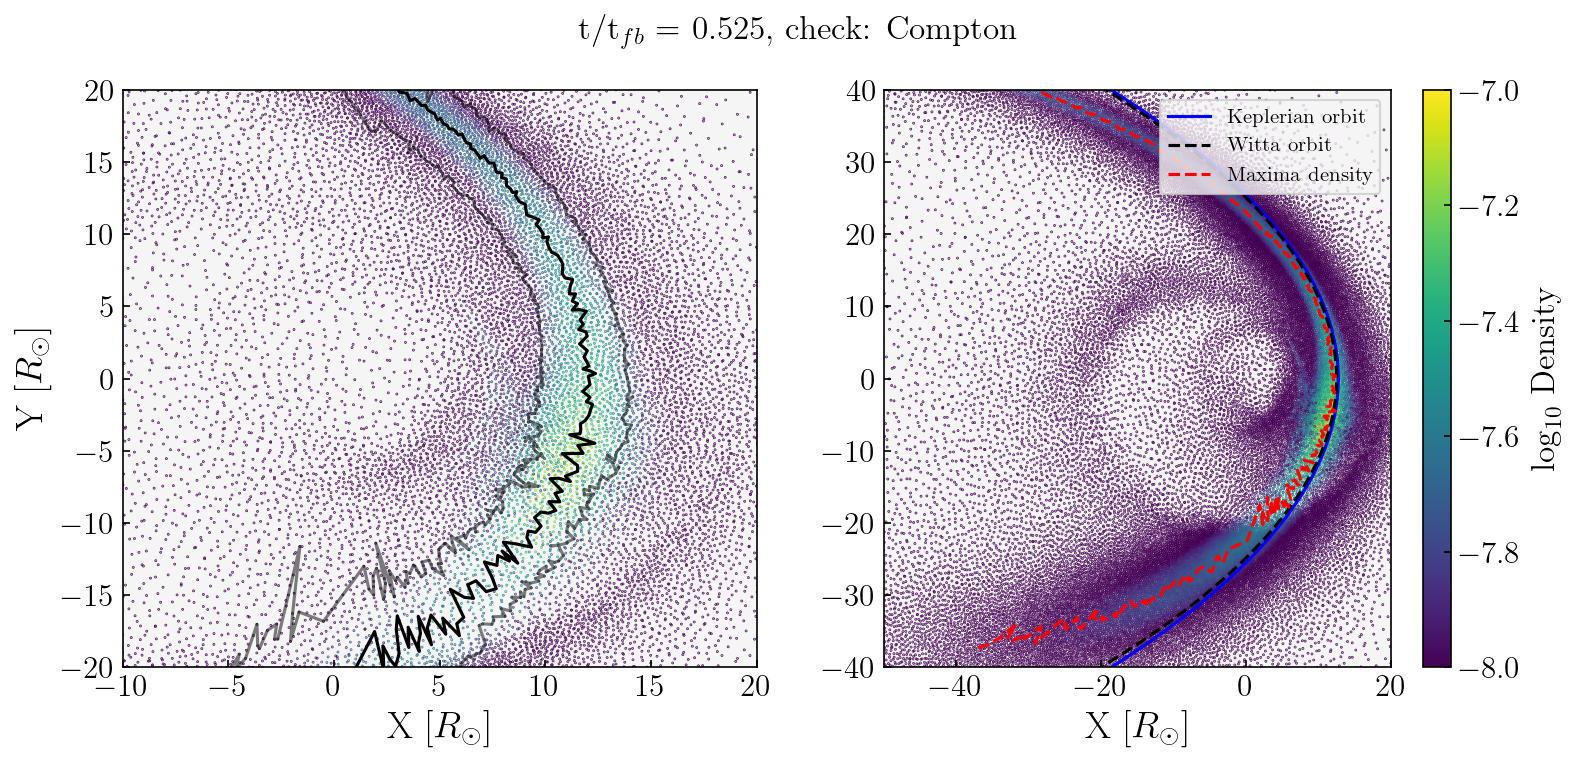

In [42]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'viridis', vmin = -8, vmax = -7)
ax[0].plot(cm[0], cm[1], c = 'k')
ax[0].plot(upper_tube[0], upper_tube[1],  c = 'k', alpha = 0.5)
ax[0].plot(lower_tube[0], lower_tube[1],  c = 'k', alpha = 0.5)
ax[0].set_xlim(-10,20)
ax[0].set_ylim(-20,20)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'viridis', vmin = -8, vmax = -7)
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[1].plot(x_orbit, y_orbit, c = 'b', label = 'Keplerian orbit')
ax[1].plot(x_Witta_orbit, y_Witta_orbit, c = 'k', linestyle = '--', label = 'Witta orbit')
ax[1].plot(cm[0], cm[1], c = 'r', linestyle = '--', label = 'Maxima density')
ax[1].set_xlim(-50,20)
ax[1].set_ylim(-40, 40)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[1].legend(loc = 'upper right')

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}', fontsize = 16)

plt.savefig(f'Figs/{folder}/{check}/width&orb.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


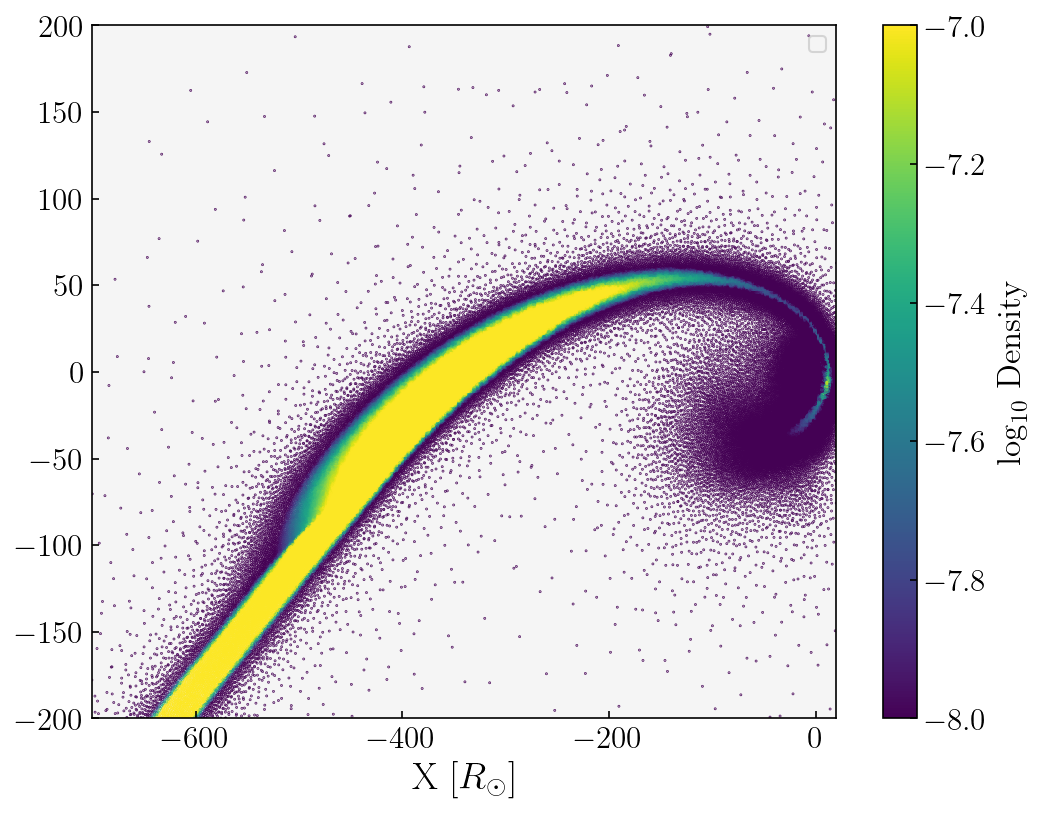

In [43]:
img1 = plt.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'viridis', vmin = -8, vmax = -7)
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 16)
# plt.plot(x_orbit, y_orbit, c = 'b', label = 'Keplerian orbit')
# plt.plot(x_Witta_orbit, y_Witta_orbit, c = 'k', linestyle = '--', label = 'Witta orbit')
#plt.plot(cm[0], cm[1], c = 'r', linestyle = '--', label = 'Maxima density')
plt.xlim(-700,20)
plt.ylim(-200, 200)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.legend(loc = 'upper right')

In [44]:
r_upper = np.sqrt(upper_tube[0]**2 + upper_tube[1]**2)
r_lower = np.sqrt(lower_tube[0]**2 + lower_tube[1]**2)
cm_r = np.sqrt(cm[0]**2 + cm[1]**2)
width = r_upper - r_lower
width_over_r = width / cm_r

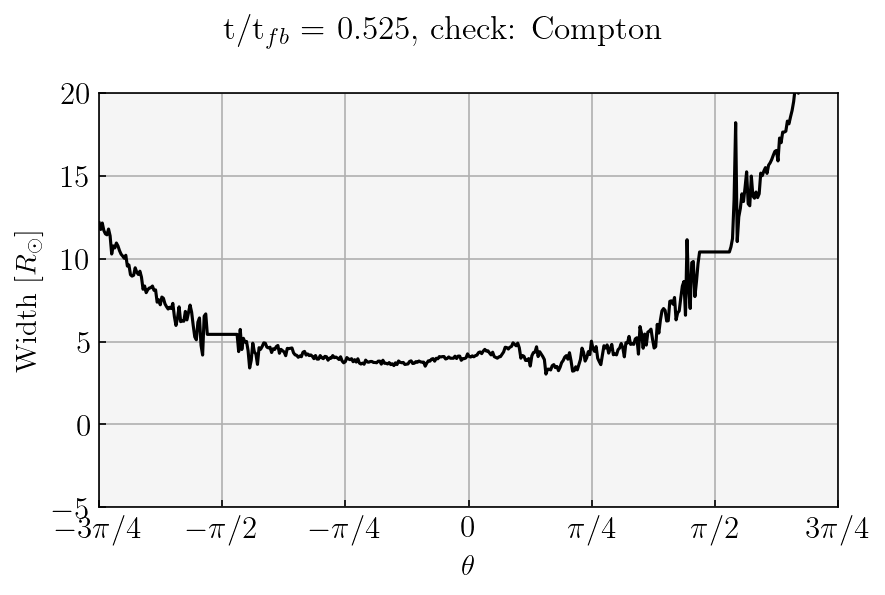

In [45]:
plt.figure(figsize=(6,4))
plt.plot(theta_arr * radians, width, c = 'k')
plt.xlabel(r'$\theta$', fontsize = 14)
plt.ylabel(r'Width [$R_\odot$]', fontsize = 14)
plt.xlim(-3/4*np.pi, 3/4*np.pi)
plt.ylim(-5,20)
plt.grid()

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}', fontsize = 16)
plt.tight_layout()
plt.savefig(f'Figs/{folder}/{check}/width.png')


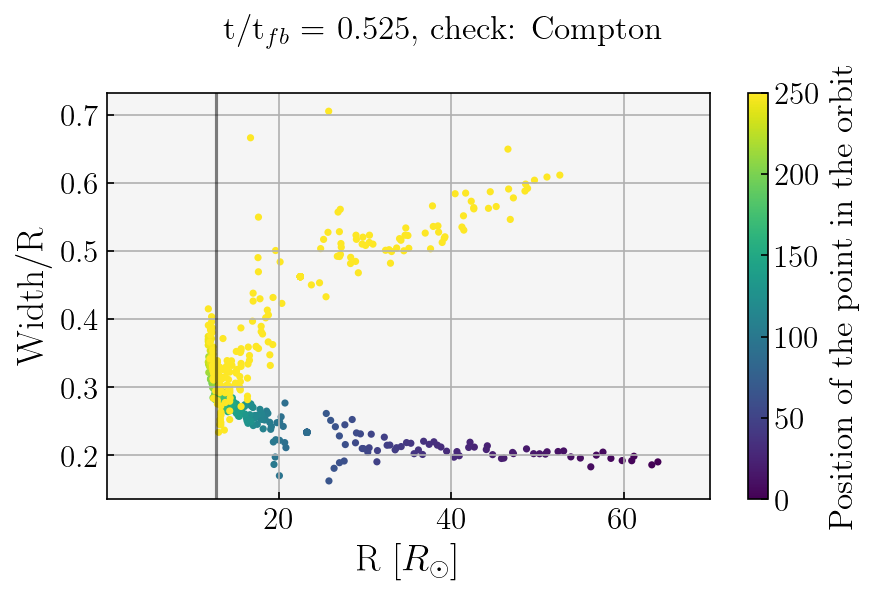

In [46]:
# if you want them sorted (according to angle) to use color and understand the order
theta_arr_list = list(theta_arr)
cm_r_sorted = sort_list(cm_r, theta_arr_list)
width_over_r_sorted = sort_list(width_over_r, theta_arr_list)
r_array = np.arange(Rp,200)

plt.figure(figsize=(6,4))
plt.axvline(Rp, c = 'k', alpha = 0.5)
img = plt.scatter(cm_r_sorted, width_over_r_sorted, c = np.arange(len(cm_r_sorted)), s = 6, vmin = 0, vmax = 250)
cbar = plt.colorbar(img)
cbar.set_label('Position of the point in the orbit', fontsize = 16)
#plt.plot(r_array, width_dependence(r_array), c = 'k', linestyle = '--', alpha = 0.5, label = r'$R^{3/2}$')
plt.xlabel(r'R [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Width/R ', fontsize = 18)
plt.xlim(Rs,70)
plt.grid()

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}', fontsize = 16)
plt.tight_layout()
plt.savefig(f'Figs/{folder}/{check}/width_over_R.png')

In [47]:
def width_dependence(r, normal = Rp):
    width_r = r**(1/2)
    return width_r

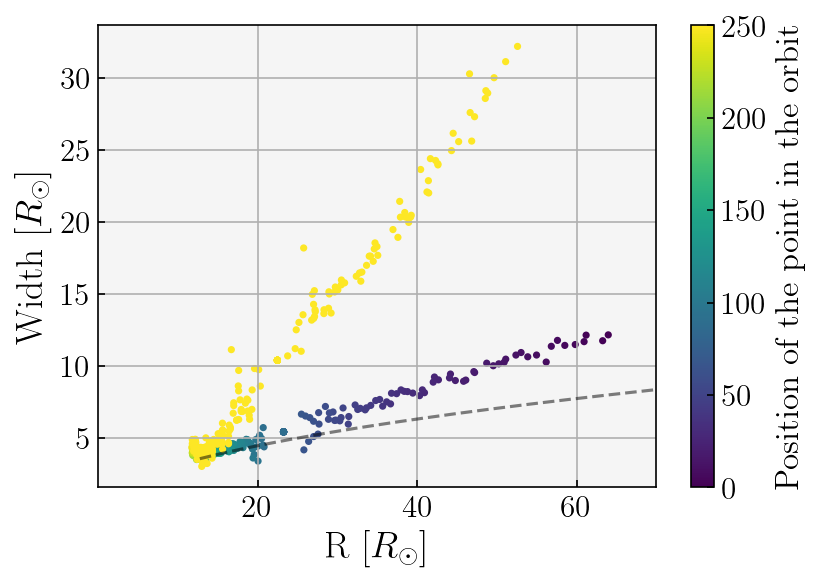

In [48]:
plt.figure(figsize=(6,4))
img = plt.scatter(cm_r_sorted, width, c = np.arange(len(cm_r_sorted)), s = 6, vmin = 0, vmax = 250)
cbar = plt.colorbar(img)
cbar.set_label('Position of the point in the orbit', fontsize = 16)
plt.plot(r_array, width_dependence(r_array), c = 'k', linestyle = '--', alpha = 0.5, label = r'$R^{1/3}$')
plt.xlabel(r'R [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Width [$R_\odot$]', fontsize = 18)
plt.xlim(Rs,70)
plt.grid()


Second strem

In [49]:
first_cm, second_cm = find_streams(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

In [50]:
# fig, ax = plt.subplots(1,1, figsize = (6,5))
# img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'viridis', vmin = -11, vmax = -6.5)
# cbar = plt.colorbar(img)
# cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
# ax.scatter(first_cm[0], first_cm[1], s = 4, c = 'k')
# ax.scatter(second_cm[0], second_cm[1], s = 4, c = 'green')
# ax.set_xlim(-100,55)
# ax.set_ylim(-60,60)

Stone13

In [51]:
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

In [52]:
z_arr = np.arange(-1, 1, .2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

(-1.0, 1.0)

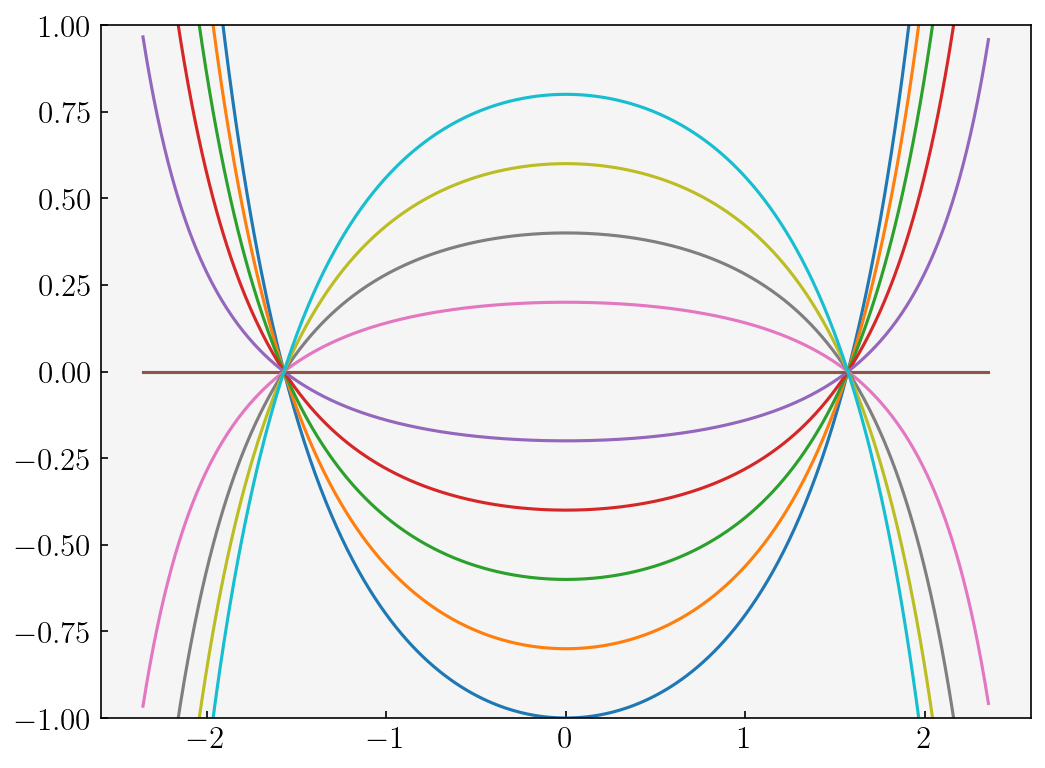

In [53]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])
plt.ylim(-1,1)